# Analyze the Effects of a Hard Wall in the z-Direction

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
from graphenetools import gt
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Do you want to process the full data set?

Default is False. The full data set can be found here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4553524.svg)](https://doi.org/10.5281/zenodo.4553524)

In [55]:
reduce_data = True

## Some helper and analysis functions

In [5]:
import layerutils
from layerutils import lab,vals,texformat,get_base_dir

# get the graphene lattice information
Am, An, b1, b2, gm, gn = gt.get_graphene_vectors(0.0)

In [6]:
import pimchelp
importlib.reload(pimchelp)
script_dir = os.environ["SCDIR"]
sys.path.append(script_dir)

## Setting up and Extracting Information from the QMC Data

In [7]:
num_sites = [24,48,96,192]
filling = [0,1/3,1]
sim_params = {'T':0.0,'canonical':True,'τ':0.00313, 'β':1.002}
Lz = np.arange(4.5,5.51,0.05)

pimcid = defaultdict(dict)
par_map = defaultdict(dict)
base_dir = defaultdict(dict)
L,n,N,τ = defaultdict(dict),defaultdict(dict),defaultdict(dict),defaultdict(dict)
N_ads = defaultdict(dict)
simulations,pimcids = {},{}
pigs_pimcids,pimc_pimcids = defaultdict(list),defaultdict(list)


for cnum in num_sites:
    Nkey = lab(N=cnum)
    cbase_dir = get_base_dir(cnum,T=sim_params['T'])
    log_names = pimchelp.get_file_list_from_params(**sim_params,base_dir=cbase_dir)
        
     # We go through each file and automatically populate the simulation map
    for log in log_names:
        par_ = pimchelp.get_parameter_map(cbase_dir + log)

        cN = par_['Initial Number Particles']
        if cN == 1:
            cf = 0
        else:
            cf = cN/cnum

        sim = lab(T=sim_params['T'],n=cf,Lz=par_['Container Length'],N=cnum)
        base_dir[Nkey][sim] = cbase_dir
        
        # sort the pimcids into two possible groups
        pimcid[Nkey][sim] = par_['PIMCID']
        if sim_params['T'] > 0:
            pimc_pimcids[Nkey].append(par_['PIMCID'])
        else:
            pigs_pimcids[Nkey].append(par_['PIMCID'])

        par_map[Nkey][sim] = par_

        # We add some short-hand variables for ease of referencing
        L[Nkey][sim] = par_map[Nkey][sim]['Container Dimensions']
        n[Nkey][sim] = par_map[Nkey][sim]['Initial Density']
        N[Nkey][sim] = par_map[Nkey][sim]['Initial Number Particles']
        τ[Nkey][sim] = par_map[Nkey][sim]['Specified Imaginary Time Step']
        N_ads[Nkey][sim] = [int(round(0.5*L[Nkey][sim][0]/An[0])),int(round(L[Nkey][sim][1]/An[1]))]

    simulations[Nkey] = list(pimcid[Nkey].keys())
    pimcids[Nkey] = list(pimcid[Nkey].values())

## Reduce Estimator Files for the Linear Density

###  We process as many jobs as possible in the same directory

In [13]:
if reduce_data:
    for cnum in num_sites[:]:
        print(f'=== N = {cnum} ===\n')
        reduce_command = f"parallel python {script_dir}/reduce-one.py -r T -i {{}} -s 0.25 --canonical {get_base_dir(cnum,T=sim_params['T'])} ::: {' '.join(pimcids[lab(N=cnum)])}"
        stream = os.popen(reduce_command)
        output = stream.read()
        print(output)

=== N = 24 ===

Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Reduced estimator over 1 Temperature value(s).
Reduced lineardensity over 1 Temperature value(s).
Redu

In [14]:
estimator = defaultdict(dict)
linear_density = defaultdict(dict)
z_lin,ρ_lin,Δρ_lin = defaultdict(dict),defaultdict(dict),defaultdict(dict)

for cnum in num_sites:
    cNkey = lab(N=cnum)
    for sim in simulations[cNkey]:
        num_particles = N[cNkey][sim]

        reduce_params = {'canonical':True,'reduce':'T', 'pimcid':pimcid[cNkey][sim],'base_dir':base_dir[cNkey][sim]}
        estimator[cNkey][sim] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params,estimator='estimator'))
        linear_density[cNkey][sim] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params,
                                                                                   estimator='lineardensity'))

        reduce_par = linear_density[cNkey][sim].params[0]
        z_lin[cNkey][sim] = linear_density[cNkey][sim].x(reduce_par)+L[cNkey][sim][2]/2
        ρ_lin[cNkey][sim] = linear_density[cNkey][sim].y(reduce_par)*L[cNkey][sim][0]*L[cNkey][sim][1]/num_particles
        Δρ_lin[cNkey][sim] = linear_density[cNkey][sim].Δy(reduce_par)*L[cNkey][sim][0]*L[cNkey][sim][1]/num_particles

## Check for missing values

We only have partial coverage of parameters for $96$ and $192$ adsorption sites.


In [15]:
for j,cnum in enumerate(num_sites):
    cNkey = lab(N=cnum)
    for i,cf in enumerate(filling):        
        for k,cLz in enumerate(Lz):
            
            sim = lab(T=sim_params['T'],n=cf,Lz=cLz,N=cnum) 
            
            if cnum in num_sites:
                try:
                    if True in np.isnan(ρ_lin[cNkey][sim]):
                        #print(f'*{pimcid[cNkey][sim]}*', end=' ')
                        print('NaN: ',sim)
                except:
                    print('Missing: ', sim)

Missing:  T = 0.00 K, Lz = 4.50 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.55 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.60 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.65 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.70 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.75 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.80 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.85 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.90 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 4.95 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.00 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.05 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.10 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.15 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.20 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.25 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.30 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.35 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.40 Å, N = 096, n = 0
Missing:  T = 0.00 K, Lz = 5.45 Å, N = 096, n = 0


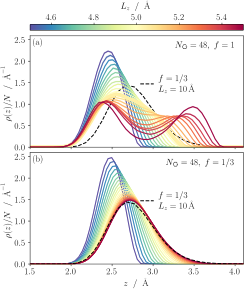

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
import matplotlib as mpl
from fractions import Fraction
from scipy import interpolate

colors = colortools.get_linear_colors('Spectral',len(Lz),reverse=True)
ncols = 1 #len(simulations)

cnum_sites = [48]
cfilling = [1,1/3]
_figsize=(1.125*len(cnum_sites)*figsize[0],len(cfilling)*figsize[1])

fig,ax = plt.subplots(nrows=len(cfilling),ncols=len(cnum_sites),sharex=True, sharey=True,
                      figsize=_figsize,squeeze=False,constrained_layout=False)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for j,cnum in enumerate(cnum_sites):
    cNkey = lab(N=cnum)

    for i,cf in enumerate(cfilling):
        
        ax[i,j].set_ylim(0,2.59)
        
        if cf == 0:
            df = Fraction(1/cnum).limit_denominator()
        else:
            df = Fraction(cf).limit_denominator()
        
        for k,cLz in enumerate(Lz):
            
            sim = lab(T=sim_params['T'],n=cf,Lz=cLz,N=cnum)             
            if sim in ρ_lin[cNkey]:
                x,y = z_lin[cNkey][sim],ρ_lin[cNkey][sim]
                f = interpolate.interp1d(x,y,kind='cubic')
                _x = np.linspace(x[0],x[-1],10000)
                #ax[i,j].plot(_x,f(_x), color=colors[k],lw=1)
                
                ax[i,j].fill_between(x,y-Δρ_lin[cNkey][sim],y+Δρ_lin[cNkey][sim], color=colors[k], 
                                    alpha=0.25, zorder=-100)

                if np.abs(cLz-5.05) < 0.01 and cf==1:
                    lw = 4
                else:
                    lw = 1
                ax[i,j].plot(z_lin[cNkey][sim],ρ_lin[cNkey][sim], color=colors[k],lw=lw)
            else:
                print(sim)

        ax[i,j].annotate(f'$N_\graphene = {cnum},\ f = {df}$', xy=(0.98,0.95),xytext=(0.98, 0.95), 
                            xycoords='axes fraction', ha='right', va='top')
        
        
    # Now we plot the bulk data
    sim = lab(T=sim_params['T'],n=1/3,Lz=10.0,N=cnum)             
    if sim in ρ_lin[cNkey]:
        ax[0,j].plot(z_lin[cNkey][sim],ρ_lin[cNkey][sim], color='k', ls='--', lw=1,
                      zorder=-10, label=r'$f=1/3$' + '\n' + r'$L_z = 10\, \mathrm{\AA}$')
        ax[1,j].plot(z_lin[cNkey][sim],ρ_lin[cNkey][sim], color='k', ls='--', lw=1,
                      zorder=10, label=r'$f=1/3$' + '\n' + r'$L_z = 10\, \mathrm{\AA}$')

loc = 'upper left'
axins1 = inset_axes(ax[0,0],
                    width="100%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc=loc,
                    bbox_to_anchor=(0.0, 1.15, 1.0, 1.0),
                    bbox_transform=ax[1,-1].transAxes,
                    borderpad=0)


sm = plt.cm.ScalarMappable(cmap=mpl.cm.Spectral_r, norm=plt.Normalize(vmin=Lz[0], vmax=Lz[-1]))
sm._A = []
cb = fig.colorbar(sm, cax=axins1, orientation='horizontal')

cb.set_label(r"$\alabel{L_z}{\angstrom}$",labelpad=5)    
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.xaxis.set_tick_params(pad=1)

ax[0,0].annotate('(a)', xy=(0.01,0.98),ha='left', va='top', xycoords='axes fraction')
ax[1,0].annotate('(b)', xy=(0.01,0.98),ha='left', va='top', xycoords='axes fraction')


#ax[-1,0].axis('off')
ax[0,0].set_xlim(1.5,4.1)
#for j in range(1,len(num_sites)):
#    ax[0,j].set_yticklabels([])
#for j in range(2,len(num_sites)):
#    ax[1,j].set_yticklabels([])

for j in range(len(cfilling)):
    ax[j,0].set_ylabel(r'$\alabel{\rho(z)/N}{\angstrom^{-1}}$')

ax[0,0].legend(loc=(0.5,0.45),handlelength=1.5)
ax[1,0].legend(loc=(0.5,0.45),handlelength=1.5)

for j in range(len(cnum_sites)):
    ax[-1,j].set_xlabel(r'$\alabel{z}{\angstrom}$')
plt.savefig('../plots/rho_z_Lz.pdf')
plt.savefig('../plots/rho_z_Lz.svg')

## Output this data to disk

In [17]:
import pickle

with open('../data/rholinear_vs_z.pickle','wb') as handle:
    pickle.dump([z_lin,ρ_lin], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Investigate higher derivatives of unit filling data

This is purely exploratory and did not end up in the final manuscript.

In [42]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.ticker as ticker
# import matplotlib as mpl
# from fractions import Fraction

# Lz = np.arange(4.5,5.51,0.05)

# colors = colortools.get_linear_colors('Spectral',len(Lz),reverse=True)

# figsize = plt.rcParams['figure.figsize']
# fig,ax = plt.subplots(nrows=1,ncols=len(simulations),sharex=True, sharey=True,
#                       figsize=(len(num_sites)/2*figsize[0],len(filling)*figsize[1]),squeeze=False)
# fig.subplots_adjust(wspace=0.05,hspace=0.05)


# for j,cnum in enumerate(num_sites[::1]):
#     cNkey = Nkey(cnum)
        
#     cf = 1.0
#     df = Fraction(cf).limit_denominator()

#     for k,cLz in enumerate(Lz):

#         sim = lab(n=cf,Lz=cLz,N=cnum)             
#         if sim in ρ_lin[cNkey]:
#             ax[0,j].plot(z_lin[cNkey][sim],np.gradient(np.gradient(ρ_lin[cNkey][sim])), color=colors[k])

#     ax[0,j].annotate(f'$N = {cnum},\ f = {df}$', xy=(0.95,0.95),xytext=(0.95, 0.95), 
#                         xycoords='axes fraction', ha='right', va='top', fontsize=12)


# #ax[0,0].set_xlim(1.5,4.5)
    
# ax[0,0].set_ylabel(r'$\rho/N\; [\mathrm{\AA}^{-1}]$')
# ax[-1,0].set_ylabel(r'$\rho/N\; [\mathrm{\AA}^{-1}]$')
# #for j in range(len(num_sites)):
# #    ax[1,j].set_xlabel(r'$z\; [\mathrm{\AA}]$')
# #plt.savefig('./plot|s/rho_z_first_layer.pdf',dpi=300)

In [43]:
# def crossings_nonzero_all(data):
#     pos = data > 0
#     npos = ~pos
#     return ((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0]

In [44]:
# for j,cnum in enumerate(num_sites[::1]):
#     cNkey = Nkey(cnum)
        
#     for k,cLz in enumerate(Lz):

#         sim = lab(n=1,Lz=cLz,N=cnum)             
#         if sim in ρ_lin[cNkey]:
#             zero_crossings = crossings_nonzero_all(np.gradient(np.gradient(ρ_lin[cNkey][sim])))
#             print(sim,z_lin[cNkey][sim][zero_crossings])

## Investigate $\chi^2$ to determine which box-height is the most natural choice

We compare with a *bulk* box with $L_z = 10$ Å.

In [46]:
from scipy import integrate,interpolate
χ2 = defaultdict(list)
Lz_min = {}
idx_min = {}

for j,cnum in enumerate(num_sites[:-2]):
    cNkey = lab(N=cnum)
    
    for k,cLz in enumerate(Lz):
            
        sim_neq1 = lab(T=sim_params['T'],n=1,Lz=cLz,N=cnum)    
        sim_neq1o3 = lab(T=sim_params['T'],n=1/3,Lz=10.0,N=cnum)
    
        if ((sim_neq1 in ρ_lin[cNkey]) and (sim_neq1o3 in ρ_lin[cNkey])):

            # normalize both values
            ρ_neq1 = ρ_lin[cNkey][sim_neq1]/integrate.simps(ρ_lin[cNkey][sim_neq1],z_lin[cNkey][sim_neq1])
            ρ_neq1o3 = ρ_lin[cNkey][sim_neq1o3]/integrate.simps(ρ_lin[cNkey][sim_neq1o3],z_lin[cNkey][sim_neq1o3])
            
            f = interpolate.interp1d(z_lin[cNkey][sim_neq1o3], ρ_neq1o3)

            norm = (z_lin[cNkey][sim_neq1][1]-z_lin[cNkey][sim_neq1][0])**2
            χ2[cNkey].append(np.sum((ρ_neq1-f(z_lin[cNkey][sim_neq1]))**2))
        else:
            χ2[cNkey].append(0)
    χ2[cNkey] = np.array(χ2[cNkey])
    Lz_min[cNkey] = Lz[np.nanargmin(χ2[cNkey])]
    idx_min[cNkey] = np.where(np.abs(Lz-Lz_min[cNkey])<0.01)[0][0]
    
    print(idx_min[cNkey],Lz_min[cNkey])

11 5.049999999999998
11 5.049999999999998


### An alternate approach where we shift the minima so that the peak location coincides

We did not use this alternative approach.

In [43]:
alternate = False

if alternate:
    from scipy import integrate,interpolate
    χ2 = defaultdict(list)
    Lz_min = {}
    idx_min = {}

    with plt.style.context('notebook'):
        for j,cnum in enumerate(num_sites[:-1]):
            cNkey = lab(N=cnum)

            for k,cLz in enumerate(Lz):

                sim_neq1 = lab(T=sim_params['T'],n=1,Lz=cLz,N=cnum)    
                sim_neq1o3 = lab(T=sim_params['T'],n=1/3,Lz=10.0,N=cnum)

                if ((sim_neq1 in ρ_lin[cNkey]) and (sim_neq1o3 in ρ_lin[cNkey])):

                    # normalize both values
                    ρ_neq1 = ρ_lin[cNkey][sim_neq1]/integrate.simps(ρ_lin[cNkey][sim_neq1],z_lin[cNkey][sim_neq1])
                    ρ_neq1o3 = ρ_lin[cNkey][sim_neq1o3]/integrate.simps(ρ_lin[cNkey][sim_neq1o3],z_lin[cNkey][sim_neq1o3])

                    zshift_neq1o3 = z_lin[cNkey][sim_neq1o3][np.argmax(ρ_lin[cNkey][sim_neq1o3])]
                    zshift_neq1 = z_lin[cNkey][sim_neq1][np.argmax(ρ_lin[cNkey][sim_neq1])]

                    zshift = zshift_neq1 - zshift_neq1o3

                    #print(zshift_neq1o3,zshift_neq1,zshift)

                    f = interpolate.interp1d(z_lin[cNkey][sim_neq1o3]-zshift_neq1o3, ρ_neq1o3)

                    f1 = interpolate.interp1d(z_lin[cNkey][sim_neq1]-zshift_neq1, ρ_neq1)

                    min_z = np.max([z_lin[cNkey][sim_neq1o3][0]-zshift_neq1o3,
                                   z_lin[cNkey][sim_neq1][0]-zshift_neq1])
                    max_z = np.min([z_lin[cNkey][sim_neq1o3][-1]-zshift_neq1o3,
                                    z_lin[cNkey][sim_neq1][-1]-zshift_neq1])

                    z_interp = np.linspace(min_z,max_z,1000)

                    χ2[cNkey].append(np.sum((f1(z_interp)-f(z_interp))**2))


                else:
                    χ2[cNkey].append(0)
            χ2[cNkey] = np.array(χ2[cNkey])
            Lz_min[cNkey] = Lz[np.nanargmin(χ2[cNkey])]
            idx_min[cNkey] = np.where(np.abs(Lz-Lz_min[cNkey])<0.01)[0][0]

            print(idx_min[cNkey],Lz_min[cNkey])

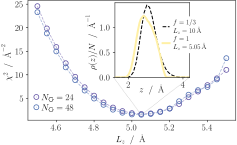

In [27]:
fig,ax = plt.subplots(figsize=(1.1*figsize[0],1.05*figsize[1]))

for i,cnum in enumerate(num_sites[:-2]):
    cNkey = lab(N=cnum)
    ax.plot(Lz,χ2[cNkey], marker='o', mfc='None', label=f'$N_{{\graphene}} = {cnum}$', 
            lw=0.75,ms=5,mew=0.75, ls='--', color=colortools.get_alpha_hex(colors[i],0.5), mec=colors[i])

#ax.axvline(x=Lz_min[lab(N=24)],color='gray', ls=':', zorder=-10, alpha=0.5,lw=0.5)

axins = inset_axes(ax, width="80%", height="80%",
                    bbox_to_anchor=(0.35, .24, .45, .78),
                    bbox_transform=ax.transAxes)

cNkey = lab(N=48)
sim_neq1 = lab(T=sim_params['T'],n=1,Lz=5.05,N=48)    
sim_neq1o3 = lab(T=sim_params['T'],n=1/3,Lz=10.0,N=48)

label_neq1o3 = r'$f=1/3$' + '\n' + r'$L_z = 10\, \mathrm{\AA}$'
label_neq1 = r'$f=1$' + '\n' + r'$L_z = 5.05\, \mathrm{\AA}$'
axins.plot(z_lin[cNkey][sim_neq1o3],ρ_lin[cNkey][sim_neq1o3], lw=1, color='k', ls='--', 
          label=label_neq1o3)
axins.plot(z_lin[cNkey][sim_neq1],ρ_lin[cNkey][sim_neq1], lw=2, color=colors[11], 
          label=label_neq1)
axins.set_xlim(1.5,4.25)
axins.set_ylim(0.0,1.49)
axins.set_ylabel(r'$\alabel{\rho(z)/N}{\angstrom^{-1}}$')
axins.set_xlabel(r'$\alabel{z}{\angstrom}$', labelpad=-5)
axins.legend(loc=(0.6,0.325), handlelength=1, facecolor='white', framealpha=1, frameon=True, 
            edgecolor='None', fontsize=7)


ax.annotate("",
            xy=(5.05, 1.5), xycoords='data',zorder=-100,
            xytext=(4.9, 9.6), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5),
            )

ax.annotate("",
            xy=(5.05, 1.5), xycoords='data',zorder=-100,
            xytext=(5.31, 9.6), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5),
            )

ax.set_xlabel(r'$\alabel{L_z}{\angstrom}$')
ax.set_ylabel(r'$\alabel{\chi^2}{\angstrom^{-2}}$')
ax.legend(loc='lower left')
plt.savefig('../plots/chi2_vs_Lz.pdf')
plt.savefig('../plots/chi2_vs_Lz.svg')

## Determine the values of Lz for which we have only 1 layer

In [42]:
from scipy.signal import argrelextrema
Lz_max = defaultdict(list)

# Figure out when we develop the 
for j,cnum in enumerate(num_sites[:-2]):
    cNkey = lab(N=cnum)
    
    for k,cLz in enumerate(Lz):
            
        sim_neq1 = lab(T=sim_params['T'],n=1,Lz=cLz,N=cnum)  
        if (sim_neq1 in ρ_lin[cNkey]):
            idx_min = argrelextrema(ρ_lin[cNkey][sim_neq1], np.less)[0]
        
        if idx_min.size > 0 and z_lin[cNkey][sim_neq1][idx_min[0]] > 2:
            Lz_max[cNkey].append(cLz)
        
    Lz_max[cNkey] = np.sort(np.array(Lz_max[cNkey]))

## Consider $V^\prime$ for $L_z = 10$ Å

In [29]:
Vp_bulk = {}
ΔVp_bulk = {}
for cnum in num_sites:
    cNkey = lab(N=cnum)
    sim_neq1o3 = lab(T=sim_params['T'],n=1/3,Lz=10,N=cnum)
    if sim_neq1o3 in estimator[cNkey]:
        Vp_bulk[cNkey] = estimator[cNkey][sim_neq1o3].data['V_int']/(cnum*3/3)
        ΔVp_bulk[cNkey] = estimator[cNkey][sim_neq1o3].data['ΔV_int']/(cnum*3/3)
        print(f"V' = {Vp_bulk[cNkey]:.5f} ± {ΔVp_bulk[cNkey]:.5f}")

V' = -2.58497 ± 0.00354
V' = -2.71606 ± 0.00161
V' = -2.73716 ± 0.00430
V' = -2.74716 ± 0.00517


### Investigate the Effects of Finite Size Scaling

[-2.75780731  2.00342378]
[0.00036638 0.01916735]


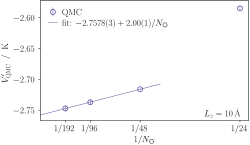

In [30]:
from scipy.optimize import curve_fit
def lin(x,Vp0,m):
    return Vp0 + m*x**1

fig,ax = plt.subplots(figsize=(1.1*figsize[0],1.05*figsize[1]))
invN,Vp_fit,ΔVp_fit = [],[],[]
for cnum in num_sites[::-1]:
    cNkey = lab(N=cnum)
    sim_neq1o3 = lab(T=sim_params['T'],n=1/3,Lz=10,N=cnum)
    if cnum==192:
        label='QMC'
    else:
        label = ''
    if sim_neq1o3 in estimator[cNkey]:
        ax.errorbar(1.0/cnum,Vp_bulk[cNkey],yerr=ΔVp_bulk[cNkey], 
                   marker='o', mfc='None', lw=0, mec=colors[0],ms=5,mew=0.75, 
                    ecolor=colors[0],elinewidth=0.5, label=label, ls='None')
        invN.append(1.0/cnum)
        Vp_fit.append(Vp_bulk[cNkey])
        ΔVp_fit.append(ΔVp_bulk[cNkey])
        
popt,pcov = curve_fit(lin,invN[:-1],Vp_fit[:-1],sigma=ΔVp_fit[:-1],p0=[-2.9,6])
invN_fit = np.linspace(0,1/40,1000)

perr = [int(np.floor(x / (10**np.floor(np.log10(x))))) for x in np.sqrt(np.diag(pcov))]
pacc = [int(-np.floor(np.log10(x))) for x in np.sqrt(np.diag(pcov))]


label = f'fit: ${popt[0]:.{pacc[0]}f}({perr[0]}) + {popt[1]:.{pacc[1]}f}({perr[1]})/N_{{\graphene}}$'
ax.plot(invN_fit, lin(invN_fit,*popt), lw=0.5, zorder=-1, color=colors[0], label=label)
ax.annotate(r'$L_z= \SI{10}{{\angstrom}}$', xy=(0.98,0.02), ha='right', va='bottom',
                        xycoords='axes fraction')
print(popt)
print(np.sqrt(np.diag(pcov)))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],loc='upper left', handlelength=1)
ax.set_xlim(0,1/23)
ax.set_xticks([1/192,1/96,1/48,1/24])
ax.set_xticklabels(['1/192','1/96','1/48','1/24'])
ax.set_xlabel(r'$1/N_{\graphene}$')
ax.set_ylabel(r'$\alabel{V^\prime_{\rm QMC}}{\kelvin}$')
plt.savefig('../plots/Vprime_QMC_fss.pdf')
plt.savefig('../plots/Vprime_QMC_fss.svg')

## Extract $V$ and $V^\prime$ from the interactions

In [31]:
V_BH = defaultdict(list)
ΔV_BH = defaultdict(list)
K,ΔK = defaultdict(list),defaultdict(list)
E,ΔE = defaultdict(list),defaultdict(list)
V_ext,ΔV_ext = defaultdict(list),defaultdict(list)
V_int,ΔV_int = defaultdict(list),defaultdict(list)
Vp_BH,ΔVp_BH = defaultdict(list),defaultdict(list)

for cnum in num_sites:
    cNkey = lab(N=cnum)

    for i,cLz in enumerate(Lz):
        sim_neq1 = lab(T=sim_params['T'],n=1,Lz=cLz,N=cnum)
        sim_neq1o3 = lab(T=sim_params['T'],n=1/3,Lz=cLz,N=cnum)
        sim_neq0 = lab(T=sim_params['T'],n=0,Lz=cLz,N=cnum)
        
        # Compute NN interaction V
        if sim_neq1 in estimator[cNkey]:
            V_BH[cNkey].append(estimator[cNkey][sim_neq1].data['V_int']/(cnum*3))
            Δ2 = (estimator[cNkey][sim_neq1].data['ΔV_int']/(cnum*3))**2
        else:
            print(sim_neq1)
            V_BH[cNkey].append(np.nan)
            Δ2 = np.nan
            
        if sim_neq1o3 in estimator[cNkey]:
            V_BH[cNkey][-1] -=  estimator[cNkey][sim_neq1o3].data['V_int']/(cnum)
            Δ2 += (estimator[cNkey][sim_neq1o3].data['ΔV_int']/cnum)**2
            
        # For computing NNN interaction V'
        if sim_neq1o3 in estimator[cNkey]:
            Vp_BH[cNkey].append(estimator[cNkey][sim_neq1o3].data['V_int']/(cnum*3))
            ΔVp_BH[cNkey].append(estimator[cNkey][sim_neq1o3].data['ΔV_int']/(cnum*3))
        else:
            print(sim_neq1o3)
            Vp_BH[cNkey].append(np.nan)
            ΔVp_BH[cNkey].append(np.nan)

        ΔV_BH[cNkey].append(np.sqrt(Δ2))
        
        # now compute quantities for all fillings
        for fill in filling:
            sim = lab(T=sim_params['T'],n=fill,Lz=cLz,N=cnum)
            cNfkey = lab(N=cnum,n=fill)
            if sim in estimator[cNkey]:
                E[cNfkey].append(estimator[cNkey][sim].data['E'])
                ΔE[cNfkey].append(estimator[cNkey][sim].data['ΔE'])
                K[cNfkey].append(estimator[cNkey][sim].data['K'])
                ΔK[cNfkey].append(estimator[cNkey][sim].data['ΔK'])
                V_ext[cNfkey].append(estimator[cNkey][sim].data['V_ext'])
                ΔV_ext[cNfkey].append(estimator[cNkey][sim].data['ΔV_ext'])   
                V_int[cNfkey].append(estimator[cNkey][sim].data['V_int'])
                ΔV_int[cNfkey].append(estimator[cNkey][sim].data['ΔV_int'])   
    
    V_BH[cNkey] = np.array(V_BH[cNkey])
    ΔV_BH[cNkey] = np.array(ΔV_BH[cNkey])
    
    Vp_BH[cNkey] = np.array(Vp_BH[cNkey])
    ΔVp_BH[cNkey] = np.array(ΔVp_BH[cNkey])
    
    for fill in filling:
        cNfkey = lab(N=cnum,n=fill)

        K[cNfkey] = np.array(K[cNfkey])
        ΔK[cNfkey] = np.array(ΔK[cNfkey])
        E[cNfkey] = np.array(E[cNfkey])
        ΔE[cNfkey] = np.array(ΔE[cNfkey])
        V_ext[cNfkey] = np.array(V_ext[cNfkey])
        ΔV_ext[cNfkey] = np.array(ΔV_ext[cNfkey]) 
        V_int[cNfkey] = np.array(V_ext[cNfkey])
        ΔV_int[cNfkey] = np.array(ΔV_ext[cNfkey]) 

T = 0.00 K, Lz = 4.50 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.55 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.60 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.65 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.70 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.75 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.80 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.85 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.90 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.95 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.00 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.05 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.10 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.15 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.20 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.25 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.30 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.35 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.40 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.45 Å, N = 096, n = 1
T = 0.00 K, Lz = 5.50 Å, N = 096, n = 1
T = 0.00 K, Lz = 4.50 Å, N = 192, n = 1
T = 0.00 K, Lz = 4.50 Å, N = 192, n = 1/3
T = 0.00 K, Lz = 4.55 Å, N = 192, n = 1
T = 0.00 K, Lz = 4.55 Å, N = 192, n = 

In [40]:
V_BH[lab(N=48)]

array([61.57102223, 61.2432981 , 60.93912022, 60.62626387, 60.02963867,
       59.63518209, 59.08538976, 58.15116177, 57.47129299, 56.4487496 ,
       55.57414683, 54.33926714, 52.83579306, 51.22410414, 49.04814621,
       45.73638753, 42.77707482, 40.5995116 , 38.79811096, 35.82664985,
       29.20214826])

In [41]:
idx_min[cNkey]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

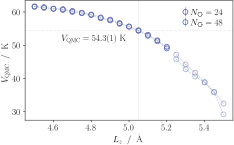

In [47]:
fig,ax = plt.subplots(figsize=(1.1*figsize[0],1.05*figsize[1]))

z_1layer = np.zeros_like(Lz, dtype=bool)

for i,cnum in enumerate(num_sites[:-2]):
    cNkey = lab(N=cnum)
    z_1layer[np.where(Lz < np.min(Lz_max[lab(N=24)]))[0]] = True
    ax.errorbar(Lz[z_1layer],V_BH[cNkey][z_1layer],ΔV_BH[cNkey][z_1layer], marker='o', mfc='None', 
                 label=f'$N_\graphene = {cnum}$', lw=0.5, mec=colors[i], 
                color=colortools.get_alpha_hex(colors[i],0.5),ms=5,mew=0.75,ls='--', 
               elinewidth=0.5,ecolor=colors[i])
    ax.errorbar(Lz[~z_1layer],V_BH[cNkey][~z_1layer], ΔV_BH[cNkey][~z_1layer], marker='o', mfc='None', 
                 lw=0.5, mec=colors[i],alpha=0.5, color=colors[i],ms=5,mew=0.75,ls='--')

cNkey = lab(N=48)
VBg = V_BH[cNkey][idx_min[cNkey]]

# we estimate uncertainty by considering the minimal finite size effects
ΔVBg = np.abs(V_BH[lab(N=48)][11]-V_BH[lab(N=24)][11])

perr = int(np.floor(ΔVBg / (10**np.floor(np.log10(ΔVBg)))))
pacc = int(-np.floor(np.log10(ΔVBg)))


ax.axvline(x=Lz_min[cNkey],color='gray', ls=':', zorder=-10, alpha=0.5,lw=0.5)
ax.axhline(y=VBg,color='gray', ls=':', zorder=-10, alpha=0.5,lw=0.5)


ax.annotate(f'$V_{{\\rm QMC}} = {VBg:.{pacc}f}({perr})\ \mathrm{{K}}$', 
            xy=(Lz_min[cNkey]-0.02,VBg-1), xycoords='data', va='top', ha='right')

ax.set_xlabel(r'$\alabel{L_z}{\angstrom}$')
ax.set_ylabel(r'$\alabel{V_{\rm QMC}}{\kelvin}$')
ax.legend()
#plt.xlim(4.8,5.2)

plt.savefig('../plots/VBH_vs_Lz.pdf')
plt.savefig('../plots/VBH_vs_Lz.svg')

In [48]:
print(V_BH[lab(N=24)][11])
print(V_BH[lab(N=48)][11])

54.50495827361111
54.339267138888886


In [49]:
print(V_BH[lab(N=48)][0])
print(V_BH[lab(N=48)][14])

61.571022229166665
49.048146208333335


In [50]:
print(V_BH[lab(N=24)][10])
print(V_BH[lab(N=24)][11])
print(V_BH[lab(N=24)][12])

55.668225174999996
54.50495827361111
53.143706375


## Investigate the variation due to FSE

In [51]:
print((V_BH[lab(N=24)][11]-V_BH[lab(N=48)][11])/V_BH[lab(N=48)][11]*100)

0.3049197080606991


FSS effects seem to be on the order of <1%.

## The Next NN interactions V'

/Users/agdelma/local/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


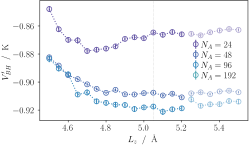

In [52]:
fig,ax = plt.subplots(figsize=(1.1*figsize[0],1.05*figsize[1]))

z_1layer = np.zeros_like(Lz, dtype=bool)
for i,cnum in enumerate(num_sites[:]):
    cNkey = lab(N=cnum)
    z_1layer[np.where(Lz < np.min(Lz_max[lab(N=24)]))[0]] = True
    ax.errorbar(Lz[z_1layer],Vp_BH[cNkey][z_1layer],ΔVp_BH[cNkey][z_1layer], marker='o', mfc='None', 
                 label=f'$N_A = {cnum}$', lw=1, mec=colors[i], color=colors[i],ms=5,mew=0.75,ls=':')
    ax.errorbar(Lz[~z_1layer],Vp_BH[cNkey][~z_1layer], ΔVp_BH[cNkey][~z_1layer], marker='o', mfc='None', 
                 lw=1, mec=colors[i],alpha=0.5, color=colors[i],ms=5,mew=0.75,ls=':')

ax.axvline(x=Lz_min[lab(N=24)],color='gray', ls=':', zorder=-10, alpha=0.5,lw=0.5)

#VBg = V_BH[Nkey(24)][np.where(np.abs(Lz-Lz_min[cNkey])<1E-6)[0][0]]
#VBg = V_BH[lab(N=24)][11]
#ΔVBg = ΔV_BH[lab(N=24)][11]
#ax.annotate(f'$V_{{BH}} = {VBg:.2f} \pm {ΔVBg:.2f}\ \mathrm{{K}}$', xy=(0.025,0.05),xytext=(0.025, 0.05), 
#                        xycoords='axes fraction')

ax.set_xlabel(r'$L_z\;\; / \;\; \mathrm{\AA}$')
ax.set_ylabel(r'$V^\prime_{BH}\;\;/\;\; \mathrm{K}$')
ax.legend()
#plt.xlim(4.8,5.2)

#plt.savefig('../plots/VBH_vs_Lz.pdf',dpi=300)

#i = 0
#for i,cz in enumerate(Lz):
#    print(cz,V_BH[cNkey][i],ΔV_BH[cNkey][i])

There seems to be relatively strong finite size effects here on the order of 5%

In [53]:
print(Vp_BH[lab(N=24)][11])
print(Vp_BH[lab(N=48)][11])
print(Vp_BH[lab(N=96)][11])
print((Vp_BH[lab(N=96)][11]-Vp_BH[lab(N=48)][11])/Vp_BH[lab(N=96)][11]*100)

-0.8646507208333333
-0.9075692777777777
-0.9174413506944445
1.0760440336806576
